# Decision Trees

Why are we learning about decision trees?

- Can be applied to both regression and classification problems
- Many useful properties
- Very popular
- Basis for more sophisticated models
- Have a different way of "thinking" than the other models we have studied

## Lesson objectives

Students will be able to:

- Explain how a decision tree is created
- Build a decision tree model in scikit-learn
- Tune a decision tree model and explain how tuning impacts the model
- Interpret a tree diagram
- Describe the key differences between regression and classification trees
- Decide whether a decision tree is an appropriate model for a given problem

# Part 1: Regression trees

Major League Baseball player data from 1986-87:

- **Years** (x-axis): number of years playing in the major leagues
- **Hits** (y-axis): number of hits in the previous year
- **Salary** (color): low salary is blue/green, high salary is red/yellow

![Salary data](images/salary_color.png)

Exercise:

- The data above is our **training data**.
- We want to build a model that predicts the Salary of **future players** based on Years and Hits.
- We are going to "segment" the feature space into regions, and then use the **mean Salary in each region** as the predicted Salary for future players.
- Intuitively, you want to **maximize** the similarity (or "homogeneity") within a given region, and **minimize** the similarity between different regions.

Rules for segmenting:

- You can only use **straight lines**, drawn one at a time.
- Your line must either be **vertical or horizontal**.
- Your line **stops** when it hits an existing line.

![Salary regions](images/salary_regions.png)

Above are the regions created by a computer:

- $R_1$: players with **less than 5 years** of experience, mean Salary of **\$166,000 **
- $R_2$: players with **5 or more years** of experience and **less than 118 hits**, mean Salary of **\$403,000 **
- $R_3$: players with **5 or more years** of experience and **118 hits or more**, mean Salary of **\$846,000 **

**Note:** Years and Hits are both integers, but the convention is to use the **midpoint** between adjacent values to label a split.

These regions are used to make predictions on **out-of-sample data**. Thus, there are only three possible predictions! (Is this different from how **linear regression** makes predictions?)

Below is the equivalent regression tree:

![Salary tree](images/salary_tree.png)

The first split is **Years < 4.5**, thus that split goes at the top of the tree. When a splitting rule is **True**, you follow the left branch. When a splitting rule is **False**, you follow the right branch.

For players in the **left branch**, the mean Salary is \$166,000, thus you label it with that value. (Salary has been divided by 1000 and log-transformed to 5.11.)

For players in the **right branch**, there is a further split on **Hits < 117.5**, dividing players into two more Salary regions: \$403,000 (transformed to 6.00), and \$846,000 (transformed to 6.74).

![Salary tree annotated](images/salary_tree_annotated.png)

**What does this tree tell you about your data?**

- Years is the most important factor determining Salary, with a lower number of Years corresponding to a lower Salary.
- For a player with a lower number of Years, Hits is not an important factor determining Salary.
- For a player with a higher number of Years, Hits is an important factor determining Salary, with a greater number of Hits corresponding to a higher Salary.

**Question:** What do you like and dislike about decision trees so far?

## Building a regression tree by hand

Your **training data** is a tiny dataset of [used vehicle sale prices](https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_train.csv). Your goal is to **predict price** for testing data.

1. Read the data into a Pandas DataFrame.
2. Explore the data by sorting, plotting, or split-apply-combine (aka `group_by`).
3. Decide which feature is the most important predictor, and use that to create your first splitting rule.
    - Only binary splits are allowed.
4. After making your first split, split your DataFrame into two parts, and then explore each part to figure out what other splits to make.
5. Stop making splits once you are convinced that it strikes a good balance between underfitting and overfitting.
    - Your goal is to build a model that generalizes well.
    - You are allowed to split on the same variable multiple times!
6. Draw your tree, labeling the leaves with the mean price for the observations in that region.
    - Make sure nothing is backwards: You follow the **left branch** if the rule is true, and the **right branch** if the rule is false.

## How does a computer build a regression tree?

**Ideal approach:** Consider every possible partition of the feature space (computationally infeasible)

**"Good enough" approach:** recursive binary splitting

1. Begin at the top of the tree.
2. For **every feature**, examine **every possible cutpoint**, and choose the feature and cutpoint such that the resulting tree has the lowest possible mean squared error (MSE). Make that split.
3. Examine the two resulting regions, and again make a **single split** (in one of the regions) to minimize the MSE.
4. Keep repeating step 3 until a **stopping criterion** is met:
    - maximum tree depth (maximum number of splits required to arrive at a leaf)
    - minimum number of observations in a leaf

### Demo: Choosing the ideal cutpoint for a given feature

In [1]:
import pandas as pd

In [2]:
# vehicle data
url = 'vehicles_train.csv'
train = pd.read_csv(url)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   price   14 non-null     int64 
 1   year    14 non-null     int64 
 2   miles   14 non-null     int64 
 3   doors   14 non-null     int64 
 4   vtype   14 non-null     object
dtypes: int64(4), object(1)
memory usage: 688.0+ bytes


In [6]:
train

,price,year,miles,doors,vtype
0,22000,2012,13000,2,car
1,14000,2010,30000,2,car
2,13000,2010,73500,4,car
3,9500,2009,78000,4,car
4,9000,2007,47000,4,car
5,4000,2006,124000,2,car
6,3000,2004,177000,4,car
7,2000,2004,209000,4,truck
8,3000,2003,138000,2,car
9,1900,2003,160000,4,car


<AxesSubplot:>

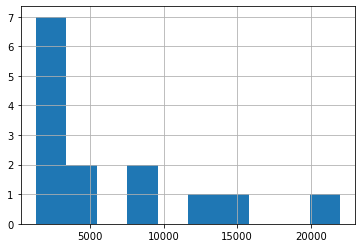

In [7]:
train.price.hist()

In [8]:
train.price.mean()

6571.428571428572

In [9]:
# before splitting anything, just predict the mean of the entire dataset
train['prediction'] = train.price.mean()
train

,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,6571.428571
1,14000,2010,30000,2,car,6571.428571
2,13000,2010,73500,4,car,6571.428571
3,9500,2009,78000,4,car,6571.428571
4,9000,2007,47000,4,car,6571.428571
5,4000,2006,124000,2,car,6571.428571
6,3000,2004,177000,4,car,6571.428571
7,2000,2004,209000,4,truck,6571.428571
8,3000,2003,138000,2,car,6571.428571
9,1900,2003,160000,4,car,6571.428571


In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [11]:
# MSE or RMSE
print('RMSE:', np.sqrt(mean_squared_error( train.price, train.prediction )))

RMSE: 5936.981985995983


#### split the data (price) based n miles >= 80k and < 80k

In [17]:
# Method 1:
v1 = train.loc[ train.miles >= 80000, 'price' ].mean()
v2 = train.loc[ train.miles < 80000, 'price' ].mean()

# create a new predicted column
train['y_pred1'] = pd.Series( np.where( train.miles >= 80000, v1, v2 ) )

# get the MSE
print('RMSE:', np.sqrt(mean_squared_error( train.price, train.y_pred1 )))

RMSE: 3530.146530076269


In [28]:
# define a function that calculates the RMSE for a given split of miles
def mileage_split( miles ):
    
    lower_mileage_price = train[train.miles < miles].price.mean()
    higher_mileage_price = train[train.miles >= miles].price.mean()
    train['prediction'] = np.where(train.miles < miles, lower_mileage_price, higher_mileage_price)
    
    return np.sqrt(mean_squared_error(train.price, train.prediction)).round(1)

In [19]:
# calculate RMSE for tree which splits on miles < 50000
print ('RMSE:', mileage_split(50000))

RMSE: 3984.0917425414564


In [20]:
# calculate RMSE for tree which splits on miles < 70000
print('RMSE:', mileage_split(70000))

RMSE: 4603.104542433446


In [21]:
# calculate RMSE for tree which splits on miles < 100000
print('RMSE:', mileage_split(100000))

RMSE: 3530.146530076269


In [24]:
print( list(range( train.miles.min(), train.miles.max(), 1000 )) )

[13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000, 101000, 102000, 103000, 104000, 105000, 106000, 107000, 108000, 109000, 110000, 111000, 112000, 113000, 114000, 115000, 116000, 117000, 118000, 119000, 120000, 121000, 122000, 123000, 124000, 125000, 126000, 127000, 128000, 129000, 130000, 131000, 132000, 133000, 134000, 135000, 136000, 137000, 138000, 139000, 140000, 141000, 142000, 143000, 144000, 145000, 146000, 147000, 148000

In [29]:
# check all possible mileage splits
mileage_range = range( train.miles.min(), train.miles.max(), 1000 )
RMSE = [mileage_split(miles) for miles in mileage_range]

In [30]:
print( RMSE )

[5937.0, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 4115.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3671.4, 3984.1, 3984.1, 3984.1, 3984.1, 3984.1, 3984.1, 3984.1, 3984.1, 3984.1, 3984.1, 3984.1, 3984.1, 3984.1, 3984.1, 3984.1, 4603.1, 4603.1, 4603.1, 4603.1, 4603.1, 4603.1, 4603.1, 4603.1, 4603.1, 4603.1, 4603.1, 3880.3, 3880.3, 3880.3, 3880.3, 3880.3, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 3530.1, 4032.7, 4032.7, 4032.7, 4032.7, 4032.7, 4032.7, 4032.7, 4032.7, 4032.7, 4032.7, 4032.7, 4032.7, 4032.7,

In [31]:
# allow plots to appear in the notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

<IPython.core.display.Javascript object>


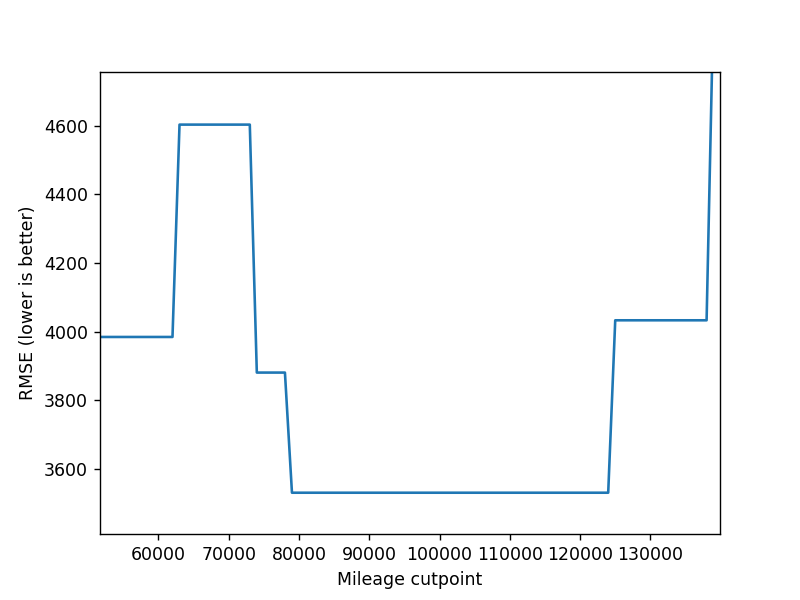

In [32]:
%matplotlib notebook
# plot mileage cutpoint (x-axis) versus RMSE (y-axis)
plt.plot(mileage_range, RMSE)
plt.xlabel('Mileage cutpoint')
plt.ylabel('RMSE (lower is better)')
plt.show()

**Recap:** Before every split, this process is repeated for every feature, and the feature and cutpoint that produces the lowest MSE is chosen.

- For a classification tree, the same process will be used, and we will measure the Entropy at for each variable, for each value of that variable. 
- The variable + value combination that yields the lowest Entropy will be chosen as the splitting rule.

## Building a regression tree in scikit-learn

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       14 non-null     int64  
 1   year        14 non-null     int64  
 2   miles       14 non-null     int64  
 3   doors       14 non-null     int64  
 4   vtype       14 non-null     object 
 5   prediction  14 non-null     float64
 6   y_pred1     14 non-null     float64
dtypes: float64(2), int64(4), object(1)
memory usage: 912.0+ bytes


#### for categorical features, create the dummy variables

In [38]:
pd.get_dummies( train.vtype, prefix = 'vtype', drop_first = True ).head(2)

,vtype_truck
0,0
1,0


In [42]:
pd.Series( np.where( train.vtype == 'car', 0, 1 )).head(2)

0    0
1    0
dtype: int32

In [43]:
# encode car as 0 and truck as 1
train['vtype'] = train.vtype.map( {'car': 0, 'truck': 1} )

In [44]:
# define X and y
feature_cols = ['year', 'miles', 'doors', 'vtype']
X_train = train[feature_cols]
y_train = train.price

In [46]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

#### Model 1 - without regularization and cv

In [47]:
# instantiate a DecisionTreeRegressor ( with random_state = 1 )
treereg = DecisionTreeRegressor( random_state = 1 ).fit( X_train, y_train )
y_predicted = treereg.predict( X_train )

In [48]:
mean_squared_error( y_train, y_predicted )

0.0

#### Model 2 - without regularization but we have done the cv

In [50]:
from sklearn.model_selection import cross_val_score

In [51]:
# use leave-one-out cross-validation (LOOCV)
scores = cross_val_score( estimator = DecisionTreeRegressor( random_state = 1 ), 
                   X = X_train,
                   y = y_train,
                   cv = 14,
                   scoring = 'neg_mean_squared_error',
                   n_jobs = -1,
                   verbose = 10)

print (np.mean(np.sqrt(- scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    5.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    5.6s remaining:    1.4s


3107.1428571428573


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    5.8s finished


## What happens when we grow a tree too deep?

- Left: Regression tree for Salary **grown deeper**
- Right: Comparison of the **training, testing, and cross-validation errors** for trees with different numbers of leaves

![Salary tree grown deep](images/salary_tree_deep.png)

The **training error** continues to go down as the tree size increases (due to overfitting), but the lowest **cross-validation error** occurs for a tree with 3 leaves.

## Tuning a regression tree

Let's try to reduce the RMSE by tuning the **max_depth** parameter:

#### Model 3 - with regularization and cv

In [52]:
# try different values one-by-one
treereg = DecisionTreeRegressor( max_depth = 3, random_state = 1 )
scores = cross_val_score(treereg, X_train, y_train, cv = 14, scoring = 'neg_mean_squared_error')
np.mean(np.sqrt(-scores))

3002.3809523809527

Or, we could write a loop to try a range of values:

In [53]:
from sklearn.model_selection import GridSearchCV

In [56]:
DecisionTreeRegressor?

In [ ]:
# scoring metrics
https://scikit-learn.org/stable/modules/model_evaluation.html

In [73]:
params = { 'max_depth': range(2, 7) }

g_cv_dt = GridSearchCV( 
            estimator = DecisionTreeRegressor( random_state = 1 ),
            param_grid = params,
            cv = 10,
            n_jobs = -1,
            verbose = 10,
            scoring = 'neg_mean_squared_error'
            ).fit( X_train, y_train )

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [74]:
g_cv_dt.best_score_

-10760000.0

In [75]:
np.sqrt(-g_cv_dt.best_score_)

3280.243893371345

In [76]:
g_cv_dt.best_params_

{'max_depth': 5}

#### alternate method

In [60]:
# list of values to try
max_depth_range = range(2, 5)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor( max_depth = depth, random_state = 345 )
    MSE_scores = cross_val_score( treereg, 
                                     X_train, 
                                     y_train, 
                                     cv = 14, 
                                     scoring = 'neg_mean_squared_error',
                                     verbose = 0,
                                     n_jobs = -1 )
    
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [61]:
print (RMSE_scores)

[3345.238095238095, 3002.3809523809527, 3050.0, 2528.5714285714284, 3064.285714285714, 2600.0, 2600.0, 2600.0, 2600.0, 2600.0, 2600.0, 2600.0]


Text(0, 0.5, 'RMSE (lower is better)')

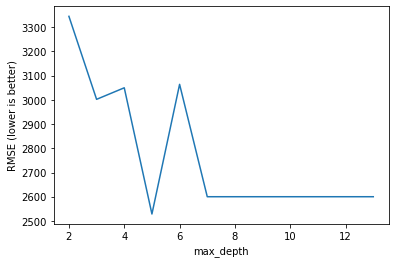

In [63]:
# plot max_depth (x-axis) versus RMSE (y-axis)
%matplotlib inline
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

#### create final model with best parameter, alternatively we can can also use best_estimator_

In [65]:
# max_depth = 5 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth = 5, random_state = 345).fit(X_train, y_train)

In [66]:
X_train.columns

Index(['year', 'miles', 'doors', 'vtype'], dtype='object')

In [67]:
treereg.feature_importances_

array([0.97999876, 0.01873341, 0.00126783, 0.        ])

In [68]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature': feature_cols, 'importance': treereg.feature_importances_})

,feature,importance
0,year,0.979999
1,miles,0.018733
2,doors,0.001268
3,vtype,0.000000


## Creating a tree diagram

In [ ]:
# create a Graphviz file
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='tree_vehicles.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_vehicles.dot -o tree_vehicles.png

![Tree for vehicle data](images/tree_vehicles.png)

Reading the internal nodes:

- **samples:** number of observations in that node before splitting
- **mse:** MSE calculated by comparing the actual response values in that node against the mean response value in that node
- **rule:** rule used to split that node (go left if true, go right if false)

Reading the leaves:

- **samples:** number of observations in that node
- **value:** mean response value in that node
- **mse:** MSE calculated by comparing the actual response values in that node against "value"

## Making predictions for the testing data

In [77]:
# read the testing data
url = 'vehicles_test.csv'
test = pd.read_csv(url)
test['vtype'] = test.vtype.map({'car': 0, 'truck': 1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


**Question:** Using the tree diagram above, what predictions will the model make for each observation?

In [78]:
# use fitted model to make predictions on testing data
X_test = test[feature_cols]
y_test = test.price

y_pred = treereg.predict(X_test)
y_pred

array([ 5000.,  5000., 13000.])

In [79]:
# calculate RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

1414.213562373095

# Part 2: Classification trees

**Example:** Predict whether Barack Obama or Hillary Clinton will win the Democratic primary in a particular county in 2008:

![Obama-Clinton decision tree](images/obama_clinton_tree.jpg)

**Questions:**

- What are the observations? How many observations are there?
- What is the response variable?
- What are the features?
- What is the most predictive feature?
- Why does the tree split on high school graduation rate twice in a row?
- What is the class prediction for the following county: 15% African-American, 90% high school graduation rate, located in the South, high poverty, high population density?
- What is the predicted probability for that same county?

## Comparing regression trees and classification trees

|regression trees|classification trees|
|---|---|
|predict a continuous response|predict a categorical response|
|predict using mean response of each leaf|predict using most commonly occuring class of each leaf|
|splits are chosen to minimize MSE|splits are chosen to minimize Gini index (discussed below)|

## Splitting criteria for classification trees

Common options for the splitting criteria:

- **classification error rate:** fraction of training observations in a region that don't belong to the most common class
- **Gini index:** measure of total variance across classes in a region

### Example of classification error rate

Pretend we are predicting whether someone buys an iPhone or an Android:

- At a particular node, there are **25 observations** (phone buyers), of whom **10 bought iPhones and 15 bought Androids**.
- Since the majority class is **Android**, that's our prediction for all 25 observations, and thus the classification error rate is **10/25 = 40%**.

Our goal in making splits is to **reduce the classification error rate**. Let's try splitting on gender:

- **Males:** 2 iPhones and 13 Androids, thus the predicted class is Android
- **Females:** 8 iPhones and 3 Androids, thus the predicted class is iPhone
- Classification error rate after this split would be **5/25 = 20%**

Compare that with a split on age:

- **30 or younger:** 4 iPhones and 8 Androids, thus the predicted class is Android
- **31 or older:** 6 iPhones and 7 Androids, thus the predicted class is Android
- Classification error rate after this split would be **10/25 = 40%**

The decision tree algorithm will try **every possible split across all features**, and choose the split that **reduces the error rate the most.**

### Example of Gini index

Calculate the Gini index before making a split:

$$1 - \left(\frac {iPhone} {Total}\right)^2 - \left(\frac {Android} {Total}\right)^2 = 1 - \left(\frac {10} {25}\right)^2 - \left(\frac {15} {25}\right)^2 = 0.48$$

- The **maximum value** of the Gini index is 0.5, and occurs when the classes are perfectly balanced in a node.
- The **minimum value** of the Gini index is 0, and occurs when there is only one class represented in a node.
- A node with a lower Gini index is said to be more "pure".

Evaluating the split on **gender** using Gini index:

$$\text{Males: } 1 - \left(\frac {2} {14}\right)^2 - \left(\frac {12} {14}\right)^2 = 0.24$$
$$\text{Females: } 1 - \left(\frac {8} {11}\right)^2 - \left(\frac {3} {11}\right)^2 = 0.40$$
$$\text{Weighted Average: } 0.24 \left(\frac {14} {25}\right) + 0.40 \left(\frac {11} {25}\right) = 0.31$$

Evaluating the split on **age** using Gini index:

$$\text{30 or younger: } 1 - \left(\frac {4} {12}\right)^2 - \left(\frac {8} {12}\right)^2 = 0.44$$
$$\text{31 or older: } 1 - \left(\frac {6} {13}\right)^2 - \left(\frac {7} {13}\right)^2 = 0.50$$
$$\text{Weighted Average: } 0.44 \left(\frac {12} {25}\right) + 0.50 \left(\frac {13} {25}\right) = 0.47$$

Again, the decision tree algorithm will try **every possible split**, and will choose the split that **reduces the Gini index (and thus increases the "node purity") the most.**

### Comparing classification error rate and Gini index

- Gini index is generally preferred because it will make splits that **increase node purity**, even if that split does not change the classification error rate.
- Node purity is important because we're interested in the **class proportions** in each region, since that's how we calculate the **predicted probability** of each class.
- scikit-learn's default splitting criteria for classification trees is Gini index.

Note: There is another common splitting criteria called **cross-entropy**. It's numerically similar to Gini index, but slower to compute, thus it's not as popular as Gini index.

## Building a classification tree in scikit-learn

We'll build a classification tree using the Titanic data:

In [80]:
import pandas as pd
import numpy as np

In [81]:
# read in the data
titanic = pd.read_csv('titanic_train.csv')

In [82]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [85]:
titanic.SibSp.unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [83]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [86]:
# read in the data
titanic = pd.read_csv('titanic_train.csv')

# encode female as 0 and male as 1
titanic['Sex'] = titanic.Sex.map({'female': 0, 'male': 1})

# fill in the missing values for age with the median age
titanic.Age.fillna(titanic.Age.median(), inplace = True)

# create a DataFrame of dummy variables for Embarked
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix = 'Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

# concatenate the original DataFrame and the dummy DataFrame
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# print the updated DataFrame
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,1


- **Survived:** 0=died, 1=survived (response variable)
- **Pclass:** 1=first class, 2=second class, 3=third class
    - What will happen if the tree splits on this feature?
- **Sex:** 0=female, 1=male
- **Age:** numeric value
- **Embarked:** C or Q or S

In [87]:
pd.crosstab(titanic.Pclass, titanic.Survived)

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [ ]:
titanic.corr()

In [88]:
titanic.loc[:, 'Pclass'] = titanic.Pclass.map({1:3, 2:2, 3:1})

In [89]:
# define X and y
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']
X_train = titanic[feature_cols]
y_train = titanic.Survived

In [90]:
# fit a classification tree with max_depth = 3 on all data
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score

### model tuning and cross validation

In [95]:
from sklearn.model_selection import GridSearchCV

In [97]:
parm = { 'max_depth': range(2, 8),   # [2, 3, 4, 5, 6, 7] - 6
                'min_samples_split': range(2, 5),   # [2, 3, 4]  - 3
                    'min_samples_leaf': range(1, 11) # [ 1, 2, 3, .... 10] - 10
               }

gscv_dt = GridSearchCV( estimator = DecisionTreeClassifier( random_state = 20 ),
                param_grid = parm, 
                    cv = 10, 
                      scoring = 'roc_auc', 
                        n_jobs = -1,
                            verbose = 10).fit( X_train, y_train )

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


In [98]:
gscv_dt.best_params_

{'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}

In [99]:
gscv_dt.best_score_

0.8545129445717681

DecisionTreeClassifier( 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, random_state = 20)

In [101]:
y_predicted_train = gscv_dt.best_estimator_.predict_proba( X_train )[:, 1]

In [102]:
roc_auc_score( y_train, y_predicted_train )

0.869478264574612

#### get the best cutoff

In [103]:
def fn_Get_Best_Cutoff( y_actual, y_predicted_proba ):
    
    # create a df to store the values
    df_best_cutoff = pd.DataFrame()
    
    # run the loop to get the best cutoff probability
    for iCutoff in np.arange( 0, 1, 0.01 ):
        
        # get the predicted y at the cutoff value
        y_predicted = np.where( y_predicted_proba > iCutoff, 1, 0 )
        
        # get the tp, tn, fp, fn
        cm = confusion_matrix(y_train, y_predicted)[::-1, ::-1]
        tp, tn, fp, fn, obs = cm[0, 0], cm[1, 1], cm[1, 0], cm[0, 1], cm.sum()
        senstivity = tp / (tp + fn)
        specificty = tn / (fp + tn)
        s_s = senstivity + specificty
        accuracy = ( tp + tn )/obs
        
        # create a temp dataframe to store the informtion
        temp = pd.DataFrame([iCutoff, tp, tn, fp, fn, obs, senstivity, specificty, accuracy, s_s]).T
        
        # update the dataframe with the new row
        df_best_cutoff = pd.concat([df_best_cutoff, temp], axis = 0)
    
    # give the proper column names
    df_best_cutoff.columns = ['iCutoff', 'tp', 'tn', 'fp', 'fn', 'obs', 'senstivity', 'specificty', 
                              'accuracy', 's_s']
    
    # get the best cutoff
    best_cutoff = df_best_cutoff.loc[ df_best_cutoff.s_s == df_best_cutoff.s_s.max(), 'iCutoff' ]

    # return the value
    return best_cutoff.iloc[0]

In [104]:
fn_Get_Best_Cutoff(y_train, y_predicted_train)

0.34

In [105]:
y_predicted = np.where( y_predicted_train > 0.34, 1, 0 )

In [106]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [107]:
accuracy_score( y_train, y_predicted )

0.792368125701459

In [108]:
print(classification_report(y_train, y_predicted))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       549
           1       0.69      0.84      0.76       342

    accuracy                           0.79       891
   macro avg       0.79      0.80      0.79       891
weighted avg       0.81      0.79      0.79       891



In [109]:
# compute the feature importances
pd.DataFrame({'feature': feature_cols, 'importance': treeclf.feature_importances_})

,feature,importance
0,Pclass,0.172092
1,Sex,0.415622
2,Age,0.354066
3,Embarked_Q,0.007933
4,Embarked_S,0.050288


# Part 3: Comparing decision trees with other models

**Advantages of decision trees:**

- Can be used for regression or classification
- Can be displayed graphically
- Highly interpretable
- Can be specified as a series of rules, and more closely approximate human decision-making than other models
- Prediction is fast
- Features don't need scaling
- Automatically learns feature interactions
- Tends to ignore irrelevant features
- Non-parametric (will outperform linear models if relationship between features and response is highly non-linear)

![Trees versus linear models](images/tree_vs_linear.png)

**Disadvantages of decision trees:**

- Performance is (generally) not competitive with the best supervised learning methods
    - Use Ensembles 
- Can easily overfit the training data (tuning is required)
    - Use GridSearch
- Small variations in the data can result in a completely different tree (high variance)
    - Use Ensembles to reduce the variance
- Recursive binary splitting makes "locally optimal" decisions that may not result in a globally optimal tree
- Doesn't tend to work well if the classes are highly unbalanced
- Doesn't tend to work well with very small datasets

In [ ]:
DecisionTreeRegressor, DecisionTreeClassifier